In [123]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Data Load

In [124]:
window_size = 7
batch_size = 32
shuffle_buffer = 60000

kkd = pd.read_csv('경기도_clustered.csv',encoding = 'cp949',index_col = 0)
kkd = kkd.T
kkd

date,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,고양시,...,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시,cluster
2013-01-01,63.4,67.8,77.7,60.5,68.1,53.0,92.6,92.6,66.8,69.5,...,92.6,71.1,73.0,82.4,82.0,102.8,93.6,59.7,83.2,1.0
2013-02-01,63.3,67.2,77.4,60.2,67.7,52.9,92.5,90.9,66.6,69.0,...,92.8,70.9,72.9,82.0,81.7,102.8,93.6,59.1,83.0,1.0
2013-03-01,63.2,66.9,76.9,60.0,67.4,52.6,92.4,90.1,66.3,68.6,...,92.8,70.8,72.8,81.9,81.4,102.7,93.6,58.7,82.9,1.0
2013-04-01,63.3,67.1,76.4,59.8,67.4,52.6,92.4,90.0,66.3,68.1,...,93.5,70.7,73.2,82.3,81.7,102.7,93.9,58.6,82.9,1.0
2013-05-01,63.4,67.5,76.4,59.6,67.6,52.9,92.4,89.8,66.6,68.1,...,93.8,71.0,73.6,82.3,81.9,103.6,94.7,58.8,82.9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,109.5,104.8,107.2,111.7,110.2,107.3,113.2,107.7,110.7,107.6,...,114.8,105.3,111.6,107.9,109.5,106.6,108.4,112.9,115.9,0.0
2021-12-01,109.8,105.1,107.4,112.0,110.8,107.4,114.1,107.5,111.2,108.0,...,116.1,105.6,111.6,108.4,109.8,107.2,109.0,113.0,116.7,0.0
2022-01-01,109.8,105.1,107.4,111.8,110.8,107.3,114.3,107.5,111.3,108.1,...,116.9,105.6,111.5,108.7,109.8,107.1,109.2,113.0,116.8,0.0
2022-02-01,109.6,105.0,107.3,111.6,110.7,107.3,114.3,107.4,111.3,108.0,...,117.0,105.6,111.0,108.7,109.7,107.1,109.3,112.9,116.6,0.0


In [126]:
test = pd.read_csv('경기도변수.csv',index_col = 0)

train = kkd.수원시[:-1]


In [127]:
# array 변환
train = np.asarray(train,dtype='float32')
test = np.asarray(train,dtype='float32')

normalizing

In [128]:
# normalization 진행
min_scale = np.min(train)
max_scale = np.max(train)
train -= min_scale
train /= max_scale

In [129]:
# Dataset 구성 함수
# 1차적으로 차원증가 후 텐서슬라이스에 매개변수로 전달
# ex)7일 + 1일 = 8일의 데이터 생성 (7일은 학습데이터, 1일은 정답데이터로 사용됨), drop_remainder 파라미터는 예측할 학습데이터가 7개가 안되면 삭제해서 진행
# flat_map을 이용해서 flat_map을 이용해서 8개로 생성
# shuffle을 이용해서 무작위로 섞음
# 마지막으로 7:1 (학습7,정답1)로 매핑진행
# 마지막으로 배치사이즈만큼 다시한번 매핑진행
# 참고사이트 : https://teddylee777.github.io/tensorflow/dataset-batch-window
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [130]:
# 학습용데이터로 변환
dataset = windowed_dataset(train, window_size, batch_size, shuffle_buffer)
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>

layer Create

In [131]:
# LSTM or GRU
# input_shape 는 [batch_size,1]만큼 들어갈 예정
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,input_shape=[None,1],return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,'relu'),
    tf.keras.layers.Dense(256,'relu'),
    tf.keras.layers.Dense(128,'relu'),
    tf.keras.layers.Dense(1)
])

lstm은 기본적으로 정방향으로 계산이 됩니다.

역방향으로도 계산을 진행시키면 더 정확한 연산이 가능하므로 bidirectional 메서드를 감싸줍니다.

model compile

In [132]:
# 시계열데이터라서 mse사용, optimizer는 adam으로 통일 metrics 또한 mse로 진행
model.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [133]:
# learningrate 설정 진행, 점점 더 높아지게 설정
# earlystopping 설정, 과적합 방지
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
earlystop = EarlyStopping(monitor = 'loss',mode='min',patience=10)

model fit

In [134]:
history = model.fit(dataset,epochs=150,callbacks=[lr_schedule,earlystop])

Epoch 1/150
4/4 [==============================] - 52s 193ms/step - loss: 0.0652 - mse: 0.0652 - lr: 1.0000e-08
Epoch 2/150
4/4 [==============================] - 1s 176ms/step - loss: 0.0857 - mse: 0.0857 - lr: 1.1220e-08
Epoch 3/150
4/4 [==============================] - 1s 171ms/step - loss: 0.0804 - mse: 0.0804 - lr: 1.2589e-08
Epoch 4/150
4/4 [==============================] - 1s 224ms/step - loss: 0.0806 - mse: 0.0806 - lr: 1.4125e-08
Epoch 5/150
4/4 [==============================] - 1s 162ms/step - loss: 0.0788 - mse: 0.0788 - lr: 1.5849e-08
Epoch 6/150
4/4 [==============================] - 1s 169ms/step - loss: 0.0797 - mse: 0.0797 - lr: 1.7783e-08
Epoch 7/150
4/4 [==============================] - 1s 154ms/step - loss: 0.0802 - mse: 0.0802 - lr: 1.9953e-08
Epoch 8/150
4/4 [==============================] - 1s 166ms/step - loss: 0.0806 - mse: 0.0806 - lr: 2.2387e-08
Epoch 9/150
4/4 [==============================] - 1s 164ms/step - loss: 0.0865 - mse: 0.0865 - lr: 2.5119e-08


model save

In [135]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("lstm_suwon.h5")

# It can be used to reconstruct the model identically.
lstm_model = tf.keras.models.load_model("lstm_suwon.h5")

model predict(7일씩 데이터 입력 진행)

In [136]:
# Window 사이즈 만큼 예측결과를 다시 Array로 반환
predicts = []
for time in range(len(train)-window_size):
    pred = np.array(kkd[time : time + window_size])
    pred -= min_scale
    pred /= max_scale
    
    
    pred = pred.reshape(1,-1,1)
    
    predict = model.predict(pred)
    predict *= max_scale
    predict += min_scale    
    
    predicts.append(predict[0][0])

In [137]:
predicts

[62.07774,
 62.08692,
 62.095444,
 62.099976,
 62.098625,
 62.099636,
 62.10747,
 62.11519,
 62.11704,
 62.108326,
 62.103207,
 62.098045,
 62.091473,
 62.085327,
 62.080143,
 62.08277,
 62.086353,
 62.089195,
 62.092125,
 62.093323,
 62.08934,
 62.090675,
 62.09313,
 62.097366,
 62.10026,
 62.09949,
 62.098297,
 62.09087,
 62.085087,
 62.076332,
 62.06968,
 62.062447,
 62.053886,
 62.0453,
 62.038433,
 62.036182,
 62.036697,
 62.038036,
 62.039516,
 62.041634,
 62.042294,
 62.039215,
 62.035862,
 62.033108,
 62.031593,
 62.02879,
 62.02726,
 62.02791,
 62.03055,
 62.032955,
 62.03355,
 62.03409,
 62.032494,
 62.02906,
 62.025715,
 62.020393,
 62.018303,
 62.01562,
 62.01132,
 62.00879,
 62.005413,
 61.998505,
 61.99937,
 61.99935,
 61.999718,
 61.999844,
 61.999573,
 61.99635,
 61.97986,
 61.967155,
 61.961876,
 61.960846,
 61.96248,
 61.964207,
 61.968277,
 61.976585,
 61.985336,
 61.993095,
 61.99571,
 61.99847,
 62.007008,
 62.0078,
 62.003006,
 61.99471,
 61.995934,
 61.99131,
 61

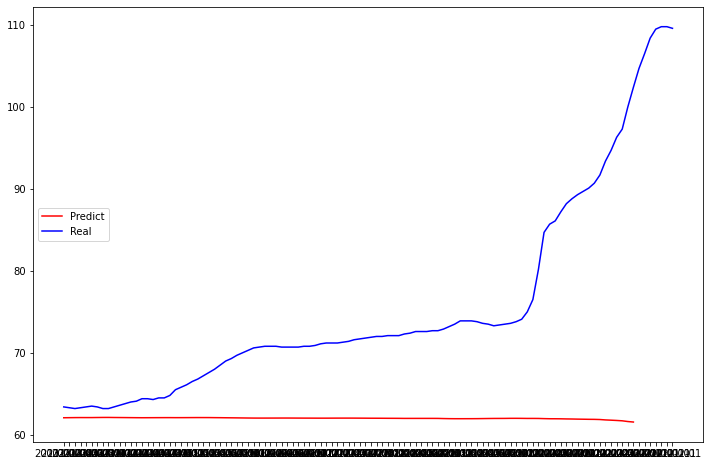

In [142]:
plt.figure(figsize=(12,8))
plt.plot(predicts,color='red',label='Predict')
plt.plot(kkd.수원시[:-1],color='blue',label='Real')
plt.legend(loc='center left')
plt.show()

예측 함수 생성

In [149]:
# 7일까지만 예측진행
future_days = 7

future_series = predicts[-window_size:]
future_series

[61.86141, 61.812786, 61.78143, 61.747105, 61.704506, 61.6164, 61.55535]

In [148]:
# 7일 예측씩 지속적으로 예측 진행
def predict_days(future_days,future_series):
    
    futures = []
    for time in range(future_days):
        pred = np.array(future_series,dtype='float64')
        pred -= min_scale
        pred /= max_scale

        pred = pred.reshape(1,-1,1)

        predict = model.predict(pred)

        predict *= max_scale
        predict += min_scale

        future_series.append(predict[0][0])
        futures.append(predict[0][0])

        future_series.pop(0)
        
    plt.plot(np.arange(future_days),futures)
    plt.title('{}months'.format(future_days))
    plt.show()
    
future_days

7

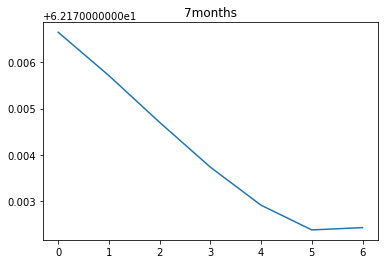

In [146]:
predict_days(future_days,future_series)